# Thermostat

Example taken from: https://arxiv.org/pdf/1410.8060

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} - \textit{temp} + 30 \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              - \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

The goal is to find the parameters $t_{on}$ and $t_{off}$ in order to maximise the probability of reaching the region $T(t) \in [19.9, 20.1]$ in mode "Heater ON (mode = -1)" at various time points $(\tau = 0.6, \tau = 1.8 \text{ and } \tau = 2.4)$.

## SOGA

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']


In [2]:
from optimization import *
torch.set_default_dtype(torch.float64)

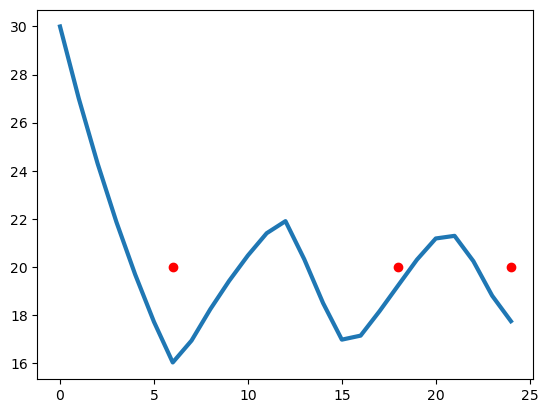

In [3]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean
orig_params = {'T': 25,   # time steps
               'init_T': 16.,  # initial temperature
               }     # turn-off temperature

soga_code = """
array[26] T;
array[26] M; 

/* Initial state */
currT = gauss(30., 1.);   
isOn = 1;                 

dt = 0.1;            

for i in range(25) {

    /* Save current state */
    T[i] = currT;
    M[i] = isOn;

    /* Continuous dynamics */
    if isOn > 0 {
        /* Cooling: dT/dt = -T */
        temp = currT * dt;
        newT = currT - temp + gauss(0., 0.1);
    } else {
        /* Heating: dT/dt = -(T-30) */
        temp = currT * dt;
        newT = currT - temp ;
        temp = 30. * dt;
        newT = newT + temp + gauss(0., 0.1);
    } end if;

    currT = newT;

    /* Mode switching */
    if isOn > 0 {
        if currT < _tOff {
            isOn = -1;
        } else {
            skip;
        } end if;
    } else {
        if currT >= _tOn {
            isOn = 1;
        } else {
            skip;
        } end if;
    } end if;

} end for;

/* Save final state */
T[25] = currT;
M[25] = isOn;

"""

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

# initialize parameters
T = orig_params['T']
init_T = orig_params['init_T']
params = {'tOff':  16.5, 'tOn':22.}
params_dict = initialize_params(params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

#plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA w true params')
# Points to which the lines should be drawn
points = [(6, 20), (18, 20), (24, 20)]

# Plot the points on the graph
for point in points:
    plt.plot(point[0], point[1], 'ro')  # Red dot at each point
#plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

In [4]:
y = []
y_var = []
for i in range(25):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('T['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('T['+ str(i) +']'), output_dist.var_list.index('T['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('thermostat2_init.csv', index=False)

In [5]:
print(output_dist.gm.marg_pdf(torch.tensor(1.).unsqueeze(0), idx = int(np.round(0.6/0.1))+25))

tensor([[274.6873]], grad_fn=<MmBackward0>)


In [6]:
dt = 0.1
time_index_1 = int(np.round(0.6/dt))
print(time_index_1)
time_index_2 = int(np.round(1.8/dt))
print(time_index_2)
time_index_3 = int(np.round(2.4/dt))
print(time_index_3)


6
18
24


In [7]:
output_dist.gm.marg_pdf(torch.tensor([-1., -1., -1.]).unsqueeze(0), idx = [1, 2, 3]).squeeze()

tensor(0., grad_fn=<SqueezeBackward0>)

In [8]:
T_idx = [i for i in range(output_dist.gm.n_dim()) if 'T[' in output_dist.var_list[i]]
M_idx = [i for i in range(output_dist.gm.n_dim()) if 'M[' in output_dist.var_list[i]]

#loss = lambda dist : -((dist.gm.marg_cdf(torch.tensor([20.1]), idx=int(np.round(0.6/dt))) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=int(np.round(0.6/dt))))*dist.gm.marg_pdf(torch.tensor(-1.).unsqueeze(-1), idx = int(np.round(0.6/dt))+25).squeeze()
                       #*(dist.gm.marg_cdf(torch.tensor([20.1]), idx=int(np.round(1.8/dt))) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=int(np.round(1.8/dt))))*dist.gm.marg_pdf(torch.tensor(-1.).unsqueeze(-1), idx = int(np.round(1.8/dt))+25).squeeze()
                       #*(dist.gm.marg_cdf(torch.tensor([20.1]), idx=int(np.round(2.4/dt))) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=int(np.round(2.4/dt))))*dist.gm.marg_pdf(torch.tensor(-1.).unsqueeze(-1), idx = int(np.round(2.4/dt))+25).squeeze())
#print(loss(output_dist))

loss = lambda dist : -((dist.gm.marg_cdf(torch.tensor([20.1]), idx=[int(np.round(0.6/dt)), int(np.round(1.8/dt)), int(np.round(2.4/dt))]) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=[int(np.round(0.6/dt)), int(np.round(1.8/dt)), int(np.round(2.4/dt))]))*dist.gm.marg_pdf(torch.tensor([-1., -1., -1.]).unsqueeze(0), idx = [int(np.round(0.6/dt))+25, int(np.round(1.8/dt))+25, int(np.round(2.4/dt))+25]).squeeze())
print(loss(output_dist))

tensor([[-6.3919e-07]], grad_fn=<NegBackward0>)


tOff: 16.500099977717845 tOn: 21.999900007951812  loss: -1.1462792221199177e-05
tOff: 16.500185867329513 tOn: 21.999830160172063  loss: -6.415420699515175e-07
tOff: 16.50026760983959 tOn: 21.999773714139764  loss: -6.435462072633383e-07
tOff: 16.50034788448289 tOn: 21.99972523721374  loss: -6.455491934145676e-07
tOff: 16.500427729997963 tOn: 21.99968215405178  loss: -6.472560795533274e-07
tOff: 16.500507622769565 tOn: 21.99964299667364  loss: -6.492300174500871e-07
tOff: 16.500587800590953 tOn: 21.999606830035074  loss: -6.511592992432124e-07
tOff: 16.50066838775752 tOn: 21.999573011955  loss: -6.532052384061684e-07
tOff: 16.500749448676817 tOn: 21.999541077171596  loss: -6.550126755048564e-07
tOff: 16.50083101602737 tOn: 21.999510674232347  loss: -6.569396655043138e-07
tOff: 16.500913104593092 tOn: 21.999481529016506  loss: -6.589872455482795e-07
tOff: 16.50099571812524 tOn: 21.999453422433813  loss: -6.609176915834907e-07
tOff: 16.50107885445472 tOn: 21.999426175545636  loss: -6.6293

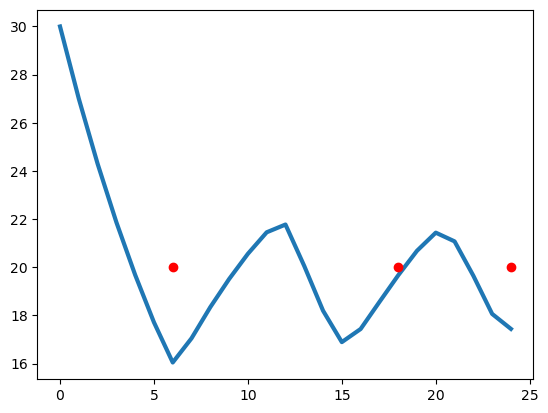

In [10]:
# Optimization in SOGA
# Define the optimizer with init_mean as the parameter
params_dict = initialize_params(params)

# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=500, lr=0.0001)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA w true params')

points = [(6, 20), (18, 20), (24, 20)]

# Plot the points on the graph
for point in points:
    plt.plot(point[0], point[1], 'ro')  # Red dot at each point

In [11]:
y = []
y_var = []
for i in range(25):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('T['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('T['+ str(i) +']'), output_dist.var_list.index('T['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('thermostat2_opt.csv', index=False)

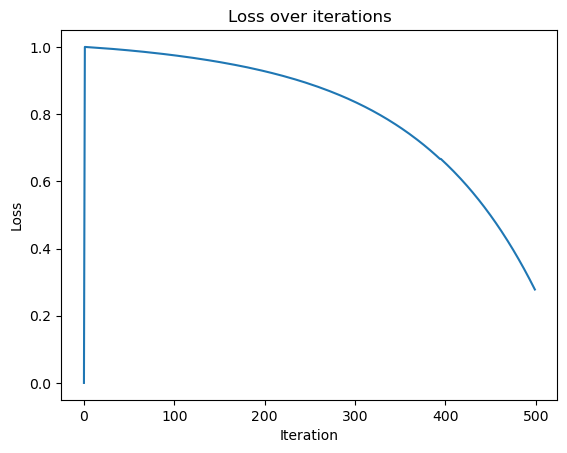

In [12]:
# export loss_list to csv
#normalize loss_list
loss_list = (np.array(loss_list) - np.min(loss_list)) / (np.max(loss_list) - np.min(loss_list))
df_loss = pd.DataFrame({'Loss': loss_list})
df_loss.to_csv('thermostat2_loss.csv', index=False)

#plot

plt.plot(df_loss['Loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()